In [10]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_brca_mRNA_data = pd.read_csv('./BRCA_mRNA.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_CNA_data = pd.read_csv('./BRCA_CNA.txt', sep=',' ,index_col=0) # Dataset has Donor ID as first column
y_brca_data = pd.read_csv('./BRCA_Clinical.txt', sep=',', index_col=0, names=["Label"]) # Dataset has Donor ID on first column and Label on second column.

X_brca_mRNA_filtered = X_brca_mRNA_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=1)
X_brca_CNA_filtered = X_brca_CNA_data.drop(["TCGA-AR-A0U1-01"], axis=1)
y_brca_filtered = y_brca_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=0)


X_train_first_norm, X_train_second_norm, X_swapped_first_norm, X_swapped_second_norm, X_test_first_norm, X_test_second_norm, X_train_concat, X_swapped_concat, X_test_concat, y_train, y_test, y_train_oh, y_test_oh \
    = Models.prepare_datasets(X_brca_mRNA_filtered.T,X_brca_CNA_filtered.T, y_brca_filtered, test_size=0.2, swap_noise=0.15)

# CONCAT TRAIN AND TEST DATASET TO TRANSFORM THE ENTIRE DATA (FOR KPCA)
X_first = pd.concat([X_train_first_norm, X_test_first_norm], axis=0)
X_second = pd.concat([X_train_second_norm, X_test_second_norm], axis=0)
y = pd.concat([y_train, y_test], axis=0)


swapping: 20 rows.


In [14]:
import importlib
importlib.reload(Models)

<module 'Models' from 'C:\\Desarrollo\\Data Science\\Jupyter Notebooks\\Stage\\oss-stage-2019\\Multiomic Dataset\\Models.py'>

Compression: 105.88

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00040: early stopping


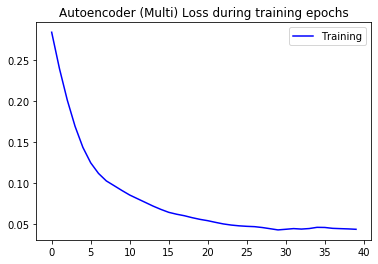

0.043129873333068995
Compression: 105.88

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00030: early stopping


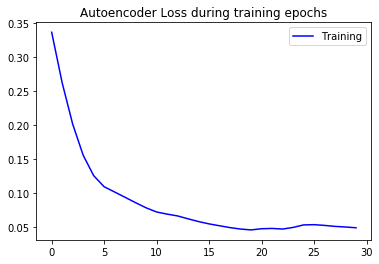

Compression: 105.88

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00108: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00131: early stopping


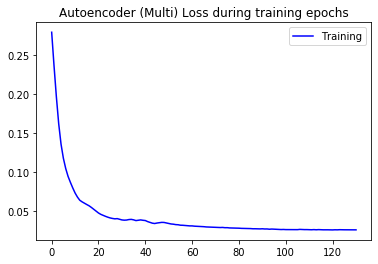

0.02554688293200273
Compression: 105.88

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00054: early stopping


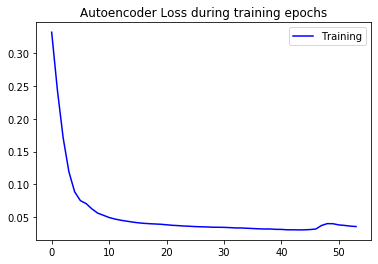

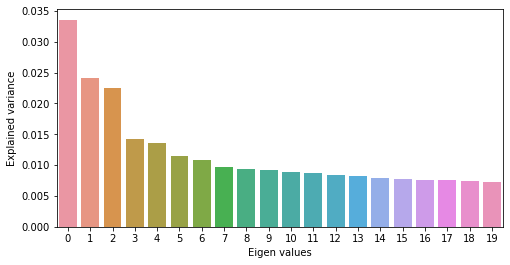

0.11938949495474545


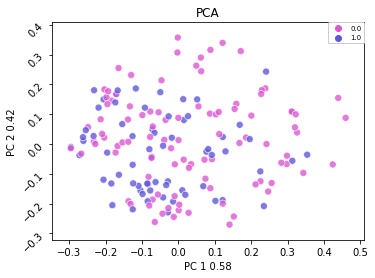

In [18]:
## Build and Train Multi Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_train_first_norm,X_train_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.00001),
                                                              dropout=0.2,
                                                              epochs=200,
                                                              mu=0.5)
## Encode datasets
X_latent_multi_ae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_ae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0.2,
                                                              epochs=200)
## Encode datasets
X_latent_ae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_ae = Models.encode_dataset(X_test_concat, encoder)

## Build and Train Multi Denoising Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_swapped_first_norm,X_swapped_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0,
                                                              epochs=200,
                                                              mu=0.5)
## Encode datasets
X_latent_multi_dae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_dae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Denoising Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_swapped_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0.2,
                                                              epochs=200)
## Encode datasets
X_latent_dae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_dae = Models.encode_dataset(X_test_concat, encoder)

# Perform rbf kernel to divided datasets
X_kpca, _ = Models.perform_multi_KPCA(X_first, X_second, y, gamma=0.008, mu=0.8)

# Split into train and test sets
X_latent_kpca, X_latent_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, test_size=0.2, random_state=1) 

Results for Original: 



C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Best score for training data: 0.6538461538461539 

Best C: 0.01 



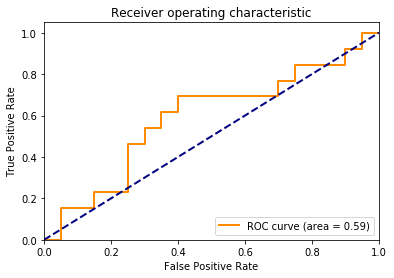

[[15  5]
 [10  3]]


              precision    recall  f1-score   support

           0       0.60      0.75      0.67        20
           1       0.38      0.23      0.29        13

    accuracy                           0.55        33
   macro avg       0.49      0.49      0.48        33
weighted avg       0.51      0.55      0.52        33

Training set score for Logistic Regression: 0.946154
Testing  set score for Logistic Regression: 0.545455
Best score for training data: 0.5923076923076923 

Best C: 0.001 

Best Gamma: 0.001 



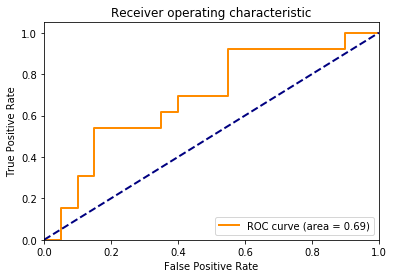

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33



C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training set score for SVM: 0.592308
Testing  set score for SVM: 0.606061
Best score for training data: 0.6538461538461539 

Best #estimators: 90 

Best max depth: 8 



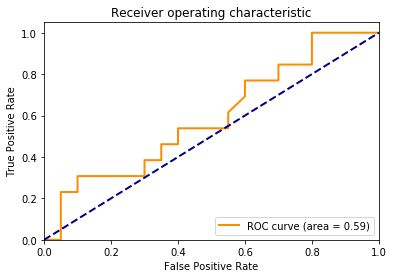

[[19  1]
 [11  2]]


              precision    recall  f1-score   support

           0       0.63      0.95      0.76        20
           1       0.67      0.15      0.25        13

    accuracy                           0.64        33
   macro avg       0.65      0.55      0.50        33
weighted avg       0.65      0.64      0.56        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.636364
Results for Multi-AE: 

Best score for training data: 0.6692307692307693 

Best C: 0.075 



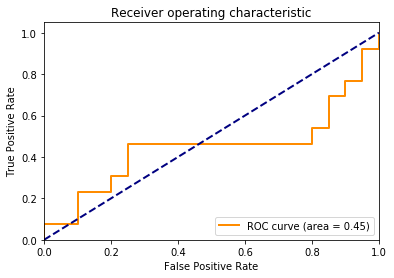

[[18  2]
 [10  3]]


              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.60      0.23      0.33        13

    accuracy                           0.64        33
   macro avg       0.62      0.57      0.54        33
weighted avg       0.63      0.64      0.59        33

Training set score for Logistic Regression: 0.692308
Testing  set score for Logistic Regression: 0.636364
Best score for training data: 0.6384615384615385 

Best C: 0.5 

Best Gamma: 0.1 



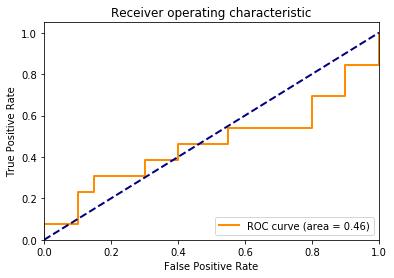

[[17  3]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.57      0.31      0.40        13

    accuracy                           0.64        33
   macro avg       0.61      0.58      0.57        33
weighted avg       0.62      0.64      0.61        33

Training set score for SVM: 0.692308
Testing  set score for SVM: 0.636364
Best score for training data: 0.6307692307692307 

Best #estimators: 80 

Best max depth: 8 



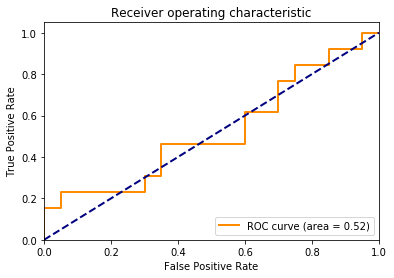

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061
Results for AE: 

Best score for training data: 0.6384615384615383 

Best C: 0.05 



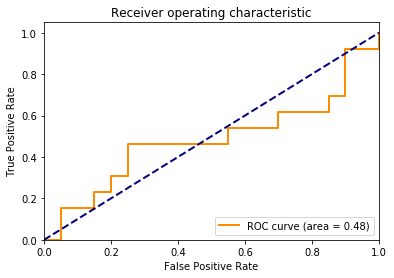

[[17  3]
 [10  3]]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72        20
           1       0.50      0.23      0.32        13

    accuracy                           0.61        33
   macro avg       0.56      0.54      0.52        33
weighted avg       0.58      0.61      0.56        33

Training set score for Logistic Regression: 0.646154
Testing  set score for Logistic Regression: 0.606061
Best score for training data: 0.6076923076923076 

Best C: 0.5 

Best Gamma: 0.5 



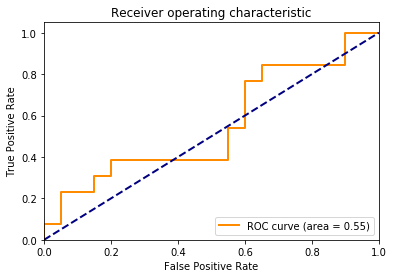

[[19  1]
 [11  2]]


              precision    recall  f1-score   support

           0       0.63      0.95      0.76        20
           1       0.67      0.15      0.25        13

    accuracy                           0.64        33
   macro avg       0.65      0.55      0.50        33
weighted avg       0.65      0.64      0.56        33

Training set score for SVM: 0.700000
Testing  set score for SVM: 0.636364
Best score for training data: 0.6461538461538462 

Best #estimators: 120 

Best max depth: 8 



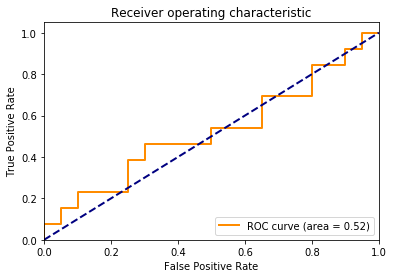

[[15  5]
 [10  3]]


              precision    recall  f1-score   support

           0       0.60      0.75      0.67        20
           1       0.38      0.23      0.29        13

    accuracy                           0.55        33
   macro avg       0.49      0.49      0.48        33
weighted avg       0.51      0.55      0.52        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.545455
Results for Multi-DAE: 

Best score for training data: 0.7 

Best C: 0.5 



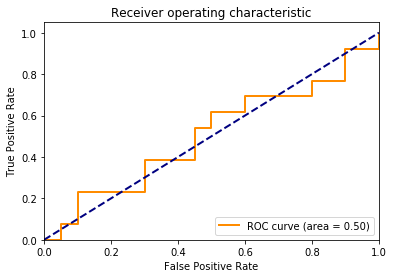

[[14  6]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.61      0.70      0.65        20
           1       0.40      0.31      0.35        13

    accuracy                           0.55        33
   macro avg       0.50      0.50      0.50        33
weighted avg       0.53      0.55      0.53        33

Training set score for Logistic Regression: 0.746154
Testing  set score for Logistic Regression: 0.545455
Best score for training data: 0.6153846153846153 

Best C: 0.5 

Best Gamma: 0.1 



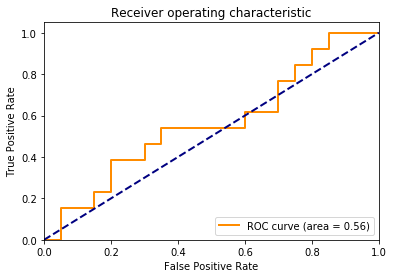

[[19  1]
 [12  1]]


              precision    recall  f1-score   support

           0       0.61      0.95      0.75        20
           1       0.50      0.08      0.13        13

    accuracy                           0.61        33
   macro avg       0.56      0.51      0.44        33
weighted avg       0.57      0.61      0.50        33

Training set score for SVM: 0.661538
Testing  set score for SVM: 0.606061
Best score for training data: 0.6153846153846153 

Best #estimators: 115 

Best max depth: 9 



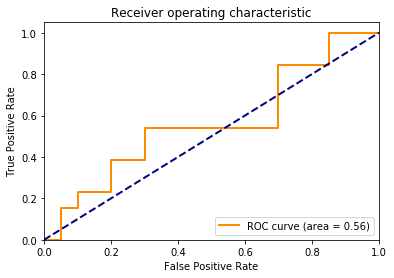

[[16  4]
 [10  3]]


              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.43      0.23      0.30        13

    accuracy                           0.58        33
   macro avg       0.52      0.52      0.50        33
weighted avg       0.54      0.58      0.54        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.575758
Results for DAE: 

Best score for training data: 0.6153846153846153 

Best C: 0.1 



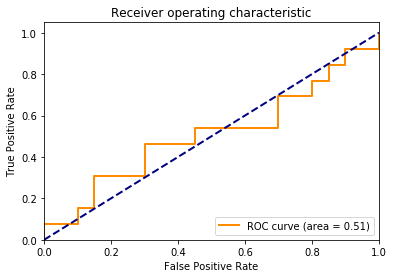

[[18  2]
 [12  1]]


              precision    recall  f1-score   support

           0       0.60      0.90      0.72        20
           1       0.33      0.08      0.12        13

    accuracy                           0.58        33
   macro avg       0.47      0.49      0.42        33
weighted avg       0.49      0.58      0.49        33

Training set score for Logistic Regression: 0.623077
Testing  set score for Logistic Regression: 0.575758
Best score for training data: 0.6076923076923076 

Best C: 0.5 

Best Gamma: 0.5 



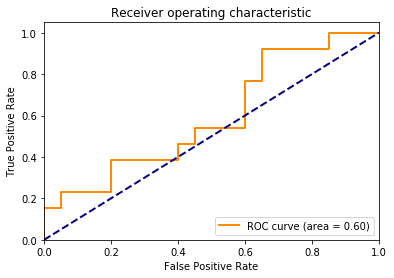

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33

Training set score for SVM: 0.630769
Testing  set score for SVM: 0.606061


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score for training data: 0.6538461538461539 

Best #estimators: 80 

Best max depth: 10 



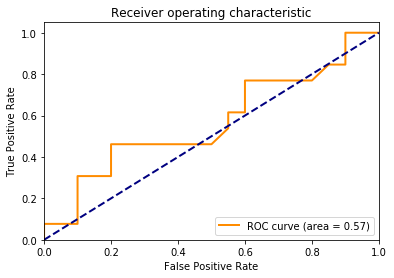

[[17  3]
 [ 9  4]]


              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.57      0.31      0.40        13

    accuracy                           0.64        33
   macro avg       0.61      0.58      0.57        33
weighted avg       0.62      0.64      0.61        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.636364
Results for KPCA: 

Best score for training data: 0.5923076923076923 

Best C: 0.0001 



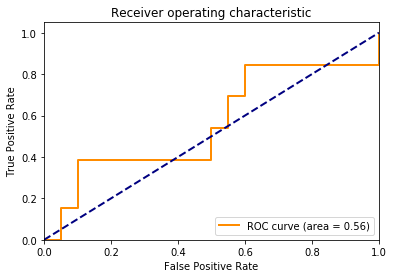

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33

Training set score for Logistic Regression: 0.592308
Testing  set score for Logistic Regression: 0.606061


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score for training data: 0.5923076923076923 

Best C: 0.001 

Best Gamma: 0.001 



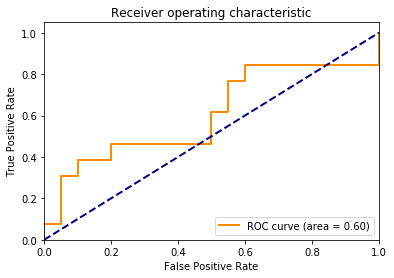

[[20  0]
 [13  0]]


              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       0.00      0.00      0.00        13

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33

Training set score for SVM: 0.592308
Testing  set score for SVM: 0.606061


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score for training data: 0.6 

Best #estimators: 80 

Best max depth: 11 



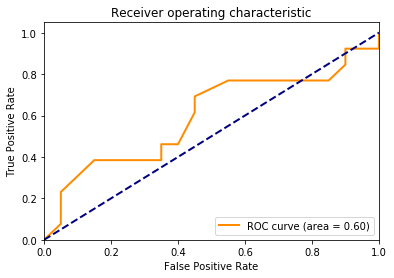

[[19  1]
 [10  3]]


              precision    recall  f1-score   support

           0       0.66      0.95      0.78        20
           1       0.75      0.23      0.35        13

    accuracy                           0.67        33
   macro avg       0.70      0.59      0.56        33
weighted avg       0.69      0.67      0.61        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.666667


In [21]:
### CLASSIFICATION ###
# We use the reduced datasets to train a classifier and compare them.
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# Original Concatenated Dataset Classification 
original_classify = Models.classify_with_cv(X_train_concat, X_test_concat, y_train, y_test, model_type="Original")
# Multi-AE Classification
multi_ae_classify = Models.classify_with_cv(X_latent_multi_ae, X_latent_test_multi_ae, y_train, y_test, model_type="Multi-AE")
# AE Classification
ae_classify = Models.classify_with_cv(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")
# Multi-DAE Classification
multi_dae_classify = Models.classify_with_cv(X_latent_multi_dae, X_latent_test_multi_dae, y_train, y_test, model_type="Multi-DAE")
# DAE Classification
dae_classify = Models.classify_with_cv(X_latent_dae, X_latent_test_dae, y_train, y_test, model_type="DAE")
# KPCA Classification
kpca_classify = Models.classify_with_cv(X_latent_kpca, X_latent_test_kpca, y_train, y_test, model_type="KPCA")

mutual information: 0.006862595132028864
Original 2 clusters -  silhoutte score: 0.042177836273676855
Original 3 clusters -  silhoutte score: 0.06183749837219053
Original 4 clusters -  silhoutte score: 0.029640064022803
Original 5 clusters -  silhoutte score: 0.0015473290101568422
Original 6 clusters -  silhoutte score: 0.008912248069880451


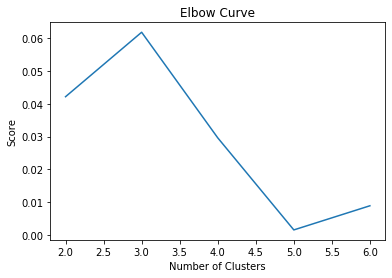

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


mutual information: 0.011230393931095218
Original 2 clusters -  silhoutte score: 0.14533286111747834
Original 3 clusters -  silhoutte score: 0.13136799112274172
Original 4 clusters -  silhoutte score: 0.11456113521196991
Original 5 clusters -  silhoutte score: 0.11055176153101469

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



Original 6 clusters -  silhoutte score: 0.099840177981586


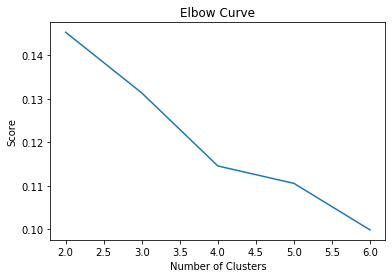

mutual information: 0.0002099322991117454
Original 2 clusters -  silhoutte score: 0.08537626590273456
Original 3 clusters -  silhoutte score: 0.07682472753645989
Original 4 clusters -  silhoutte score: 0.01714807794747394
Original 5 clusters -  silhoutte score: -0.006694630873059719
Original 6 clusters -  silhoutte score: -0.002615235833701128


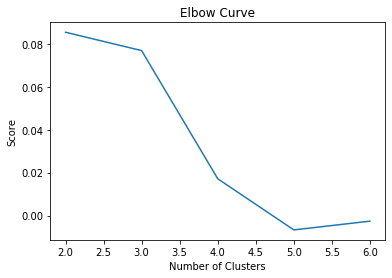

mutual information: 0.0189906032195796
AE 2 clusters -  silhoutte score: 0.23509858548641205
AE 3 clusters -  silhoutte score: 0.20440134406089783
AE 4 clusters -  silhoutte score: 0.194218710064888
AE 5 clusters -  silhoutte score: 0.20960509777069092
AE 6 clusters -  silhoutte score: 0.21742938458919525


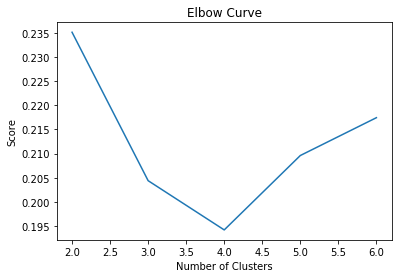

mutual information: 0.0011784587196832451
AE 2 clusters -  silhoutte score: 0.23902158439159393
AE 3 clusters -  silhoutte score: 0.1920468807220459
AE 4 clusters -  silhoutte score: 0.18642842769622803
AE 5 clusters -  silhoutte score: 0.18145722150802612
AE 6 clusters -  silhoutte score: 0.19083590805530548


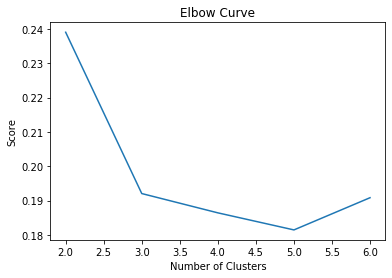

mutual information: 0.0017337162332673446
AE 2 clusters -  silhoutte score: 0.2259962260723114
AE 3 clusters -  silhoutte score: 0.1644255667924881
AE 4 clusters -  silhoutte score: 0.16279353201389313
AE 5 clusters -  silhoutte score: 0.1819806545972824
AE 6 clusters -  silhoutte score: 0.19300416111946106


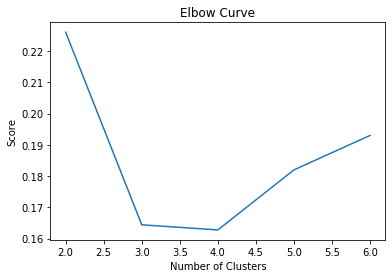

mutual information: 0.0005599936486537953
AE 2 clusters -  silhoutte score: 0.24008560180664062
AE 3 clusters -  silhoutte score: 0.24684563279151917
AE 4 clusters -  silhoutte score: 0.23090720176696777
AE 5 clusters -  silhoutte score: 0.2180604487657547
AE 6 clusters -  silhoutte score: 0.20235854387283325


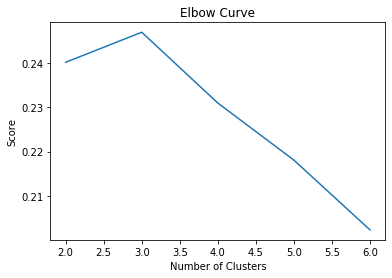

mutual information: 0.000526849824188075
AE 2 clusters -  silhoutte score: 0.26205503940582275
AE 3 clusters -  silhoutte score: 0.2360447198152542
AE 4 clusters -  silhoutte score: 0.2199413925409317
AE 5 clusters -  silhoutte score: 0.20777221024036407
AE 6 clusters -  silhoutte score: 0.19990871846675873


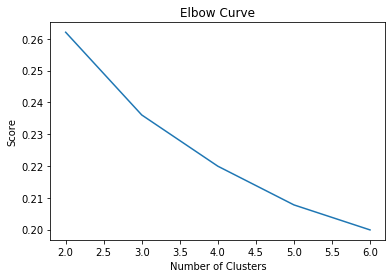

mutual information: 0.0013084426635629042
AE 2 clusters -  silhoutte score: 0.22329314053058624
AE 3 clusters -  silhoutte score: 0.22352275252342224
AE 4 clusters -  silhoutte score: 0.21768227219581604
AE 5 clusters -  silhoutte score: 0.18629273772239685
AE 6 clusters -  silhoutte score: 0.18848124146461487


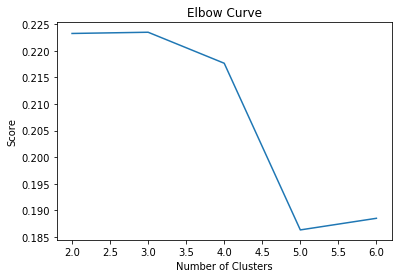

mutual information: 0.0030618186132255376
AE 2 clusters -  silhoutte score: 0.10710799694061279
AE 3 clusters -  silhoutte score: 0.11024992913007736
AE 4 clusters -  silhoutte score: 0.11155381053686142
AE 5 clusters -  silhoutte score: 0.09728054702281952
AE 6 clusters -  silhoutte score: 0.09511737525463104


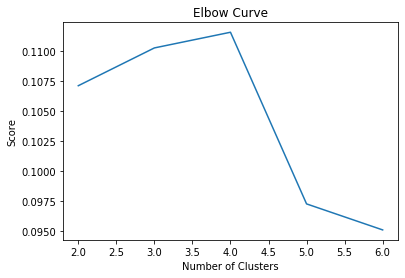

mutual information: 0.001332128860767374
AE 2 clusters -  silhoutte score: 0.1010696142911911
AE 3 clusters -  silhoutte score: 0.1079622209072113
AE 4 clusters -  silhoutte score: 0.08907565474510193
AE 5 clusters -  silhoutte score: 0.09270884841680527
AE 6 clusters -  silhoutte score: 0.09105408191680908


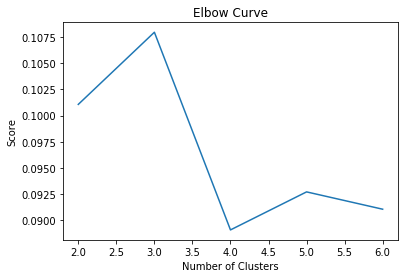

mutual information: 0.007215876314722793
AE 2 clusters -  silhoutte score: 0.11089388281106949
AE 3 clusters -  silhoutte score: 0.08121199905872345
AE 4 clusters -  silhoutte score: 0.08146660774946213
AE 5 clusters -  silhoutte score: 0.06641161441802979
AE 6 clusters -  silhoutte score: 0.049345463514328


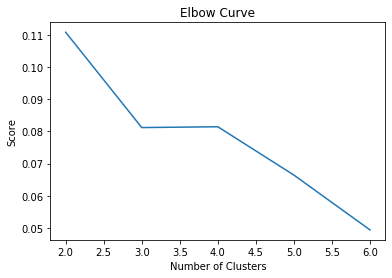

mutual information: 0.013381529455826355
AE 2 clusters -  silhoutte score: 0.18454337120056152
AE 3 clusters -  silhoutte score: 0.1998613178730011
AE 4 clusters -  silhoutte score: 0.20806339383125305
AE 5 clusters -  silhoutte score: 0.18853795528411865
AE 6 clusters -  silhoutte score: 0.1818109005689621


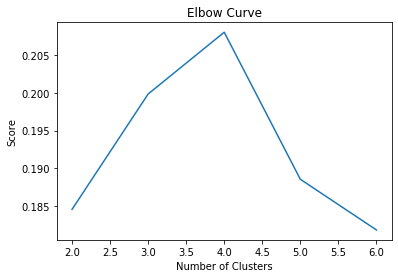

mutual information: 0.020647799706834866
AE 2 clusters -  silhoutte score: 0.19215910136699677
AE 3 clusters -  silhoutte score: 0.19985172152519226
AE 4 clusters -  silhoutte score: 0.18394294381141663
AE 5 clusters -  silhoutte score: 0.12164998054504395
AE 6 clusters -  silhoutte score: 0.16612549126148224


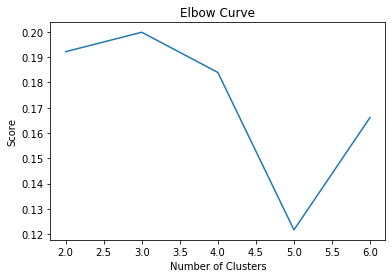

mutual information: 0.0010038477869248976
AE 2 clusters -  silhoutte score: 0.1727071851491928
AE 3 clusters -  silhoutte score: 0.1841474026441574
AE 4 clusters -  silhoutte score: 0.193018838763237
AE 5 clusters -  silhoutte score: 0.1617598533630371
AE 6 clusters -  silhoutte score: 0.15748068690299988


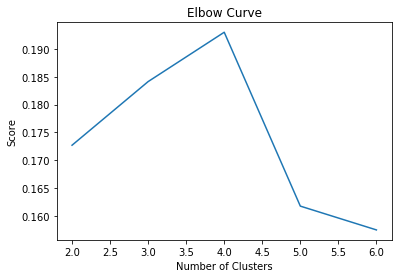

mutual information: 0.007706808287949382
AE 2 clusters -  silhoutte score: 0.013405038100250403
AE 3 clusters -  silhoutte score: 0.011080926663264443
AE 4 clusters -  silhoutte score: 0.009042415969500488
AE 5 clusters -  silhoutte score: 0.007070624534935318
AE 6 clusters -  silhoutte score: 0.008388346777813464


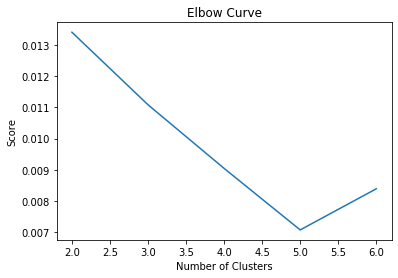

mutual information: 0.01861214449247062
AE 2 clusters -  silhoutte score: 0.0084464685049131
AE 3 clusters -  silhoutte score: -0.00018214001523099346
AE 4 clusters -  silhoutte score: 0.0007087386756439811
AE 5 clusters -  silhoutte score: -0.001920793760844535
AE 6 clusters -  silhoutte score: -0.001380001399905602


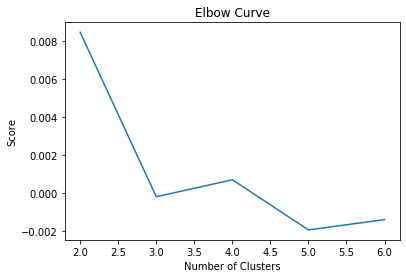

mutual information: 0.0011228240989499716
AE 2 clusters -  silhoutte score: 0.012072481995652971
AE 3 clusters -  silhoutte score: 0.012143304692152064
AE 4 clusters -  silhoutte score: 0.006777950646219804
AE 5 clusters -  silhoutte score: -0.000857138957293578
AE 6 clusters -  silhoutte score: 0.0008631757894673238


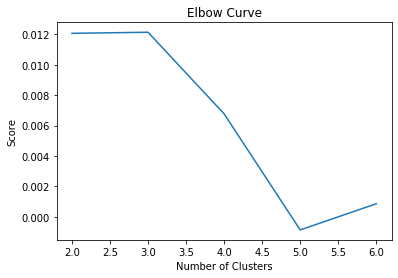

In [26]:
###### CLUSTERING ###
original_clustering = Models.cluster(X_train_concat, y_train, model_type="Original")
# Multi-AE Clustering
multi_ae_clustering = Models.cluster(X_latent_multi_ae, y_train, model_type="AE")
# AE Clustering
ae_clustering = Models.cluster(X_latent_ae, y_train, model_type="AE")
# Multi-DAE Clustering
multi_dae_clustering = Models.cluster(X_latent_multi_dae, y_train, model_type="AE")
# DAE Clustering
dae_clustering = Models.cluster(X_latent_dae, y_train, model_type="AE")
# KPCA Clustering
kpca_clustering = Models.cluster(X_latent_kpca, y_train, model_type="AE")


In [27]:
results = [original_classify + original_clustering, multi_ae_classify + multi_ae_clustering, ae_classify + ae_clustering, multi_dae_classify + multi_dae_clustering, dae_classify + dae_clustering, kpca_classify + kpca_clustering]
scores = pd.DataFrame(results, index=["Original","Multi-AE","AE","Multi-DAE","DAE","KPCA"],
                      columns=["LR_accuracy","SVM_accuracy", "RF_accuracy", "LR_auc", "SVM_auc", "RF_auc","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,LR_accuracy,SVM_accuracy,RF_accuracy,LR_auc,SVM_auc,RF_auc,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
Original,0.545455,0.606061,0.636364,0.588462,0.688462,0.590385,0.042178,0.006863,0.145333,0.011230,0.085376,0.000210
Multi-AE,0.636364,0.636364,0.606061,0.446154,0.461538,0.523077,0.235099,0.018991,0.239022,0.001178,0.225996,0.001734
AE,0.606061,0.636364,0.545455,0.480769,0.553846,0.523077,0.240086,0.000560,0.262055,0.000527,0.223293,0.001308
Multi-DAE,0.545455,0.606061,0.575758,0.503846,0.561538,0.561538,0.107108,0.003062,0.101070,0.001332,0.110894,0.007216
DAE,0.575758,0.606061,0.636364,0.507692,0.596154,0.569231,0.184543,0.013382,0.192159,0.020648,0.172707,0.001004
KPCA,0.606061,0.606061,0.666667,0.561538,0.603846,0.596154,0.013405,0.007707,0.008446,0.018612,0.012072,0.001123
